In [3]:
! pip install -q keras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
import pickle
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras import backend as K
import keras
import tensorflow as tf


1. Define configurations

In [5]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 105
        self.filters = 64
C = Config()

2. Define data processing functions

In [6]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.signal import medfilt
from scipy.ndimage import zoom as scipy_zoom
from tqdm import tqdm
from sklearn import preprocessing
import pickle
import random

# Temporal resizing function
def temporal_resizing(pose_sequence, target_length, num_joints, joint_dim):
    """
    Resize a sequence of joint positions to a target temporal length using interpolation.

    Parameters:
        pose_sequence (np.ndarray): Input pose sequence (frames, joints, dimensions).
        target_length (int): Target number of frames.
        num_joints (int): Number of joints.
        joint_dim (int): Dimensionality of each joint.

    Returns:
        np.ndarray: Resized pose sequence.
    """
    sequence_length = pose_sequence.shape[0]

    # Ensure input matches the expected dimensions
    if pose_sequence.shape[1] != num_joints or pose_sequence.shape[2] != joint_dim:
        raise ValueError(
            f"Input pose dimensions mismatch: expected ({num_joints}, {joint_dim}), got {pose_sequence.shape[1:]}"
        )

    resized_sequence = np.empty((target_length, num_joints, joint_dim))

    for joint_idx in range(num_joints):
        for dim_idx in range(joint_dim):
            # Apply median filter for smoothing
            pose_sequence[:, joint_idx, dim_idx] = medfilt(pose_sequence[:, joint_idx, dim_idx], kernel_size=3)
            # Interpolate to the target length
            resized_sequence[:, joint_idx, dim_idx] = scipy_zoom(
                pose_sequence[:, joint_idx, dim_idx], target_length / sequence_length
            )[:target_length]

    return resized_sequence

# Normalize and scale feature
def normalize_scale(feature):
    """
    Normalize and scale a feature array.

    Parameters:
        feature (np.ndarray): Input feature array.

    Returns:
        np.ndarray: Normalized and scaled feature array.
    """
    return (feature - np.mean(feature)) / np.mean(feature)

# Calculate Joint Coordinate Distance (JCD) feature
def calculate_jcd(pose_sequence, config):
    """
    Compute Joint Coordinate Distance (JCD) features.

    Parameters:
        pose_sequence (np.ndarray): Pose sequence (frames, joints, dimensions).
        config: Configuration object with `joint_n` (number of joints) and `frame_l` (frame length).

    Returns:
        np.ndarray: Normalized JCD features.
    """
    jcd_features = []
    upper_triangle_indices = np.triu_indices(config.joint_n, k=1)

    for frame in range(config.frame_l):
        # Compute pairwise Euclidean distances between joints
        distance_matrix = cdist(pose_sequence[frame], pose_sequence[frame], metric='euclidean')
        # Extract upper triangular part of the distance matrix
        upper_triangle = distance_matrix[upper_triangle_indices]
        jcd_features.append(upper_triangle)

    jcd_features = np.stack(jcd_features)
    return normalize_scale(jcd_features)

# Data augmentation function
def augment_data(pose_sequence, num_augmentations=3, crop_size_ratio=0.95, rotation_range=(-15, 15), zoom_range=(1.0, 1.2)):
    """
    Apply data augmentation to a pose sequence.

    Parameters:
        pose_sequence (np.ndarray): Original pose sequence.
        num_augmentations (int): Number of augmentations to generate.
        crop_size_ratio (float): Ratio for cropping the sequence.
        rotation_range (tuple): Range for rotation angles in degrees.
        zoom_range (tuple): Range for zoom factors.

    Returns:
        list: Original and augmented pose sequences.
    """
    augmented_sequences = [pose_sequence]

    for _ in range(num_augmentations):
        augmented = np.copy(pose_sequence)

        # Random cropping and resizing
        target_length = int(crop_size_ratio * pose_sequence.shape[0])
        start_frame = random.randint(0, pose_sequence.shape[0] - target_length)
        cropped_sequence = augmented[start_frame:start_frame + target_length]
        augmented = temporal_resizing(cropped_sequence, target_length=pose_sequence.shape[0], num_joints=pose_sequence.shape[1], joint_dim=pose_sequence.shape[2])

        # Random rotation (apply to all frames)
        rotation_angle = random.uniform(*rotation_range)
        rotation_matrix = np.array([
            [np.cos(np.radians(rotation_angle)), -np.sin(np.radians(rotation_angle))],
            [np.sin(np.radians(rotation_angle)), np.cos(np.radians(rotation_angle))]
        ])
        for frame in range(augmented.shape[0]):
            augmented[frame, :, :2] = np.dot(augmented[frame, :, :2], rotation_matrix.T)

        # Random zoom
        zoom_factor = random.uniform(*zoom_range)
        augmented[:, :, :2] *= zoom_factor

        augmented_sequences.append(augmented)

    return augmented_sequences

# Generate dataset
def generate_dataset(data, config, label_encoder, augment=False):
    """
    Generate input features and labels for the dataset.

    Parameters:
        data (dict): Input data with 'pose' and 'label'.
        config: Configuration object with frame and joint details.
        label_encoder (LabelEncoder): Fitted label encoder.
        augment (bool): Whether to apply data augmentation.

    Returns:
        tuple: Features (X_0, X_1) and labels (Y).
    """
    X_0, X_1, Y = [], [], []

    print(f"Dataset size before augmentation: {len(data['pose'])}")

    for i in tqdm(range(len(data['pose'])), desc="Processing data"):
        # Copy and resize pose sequence
        pose_sequence = np.copy(data['pose'][i])
        resized_pose = temporal_resizing(
            pose_sequence, target_length=config.frame_l, num_joints=config.joint_n, joint_dim=config.joint_d
        )

        # Apply data augmentation if specified
        sequences = augment_data(resized_pose) if augment else [resized_pose]

        for seq in sequences:
            # One-hot encode labels
            label = np.zeros(config.clc_num)
            label[label_encoder.transform([data['label'][i]])[0] - 1] = 1

            # Calculate JCD features
            jcd_features = calculate_jcd(seq, config)

            # Append to lists
            X_0.append(jcd_features)
            X_1.append(seq)
            Y.append(label)

    # Debug prints
    print(f"Generated dataset shapes: X_0: {np.array(X_0).shape}, X_1: {np.array(X_1).shape}, Y: {np.array(Y).shape}")

    # Convert lists to numpy arrays
    return np.stack(X_0), np.stack(X_1), np.stack(Y)


3. Define network

In [7]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W])
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast

def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))

    diff_slow,diff_fast = pose_motion(P,frame_l)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)

    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d))

    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)

    x = FM([M,P])

    x = GlobalMaxPool1D()(x)

    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [8]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ M (InputLayer)      │ (None, 32, 105)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ P (InputLayer)      │ (None, 32, 15, 2) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 4, 512)    │  1,714,816 │ M[0][0], P[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ functional_1[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,536 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,384 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 21)        │      2,709 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,800,469 (6.87 MB)

 Trainable params: 1,794,837 (6.85 MB)

 Non-trainable params: 5,632 (22.00 KB)


4. Load dataset (download GT_train_1.pkl and  GT_test_1.pkl from github )

In [9]:
!wget https://github.com/fandulu/DD-Net/archive/master.zip
!unzip master.zip
!rm master.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-11 23:43:51--  https://github.com/fandulu/DD-Net/archive/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master [following]
--2024-12-11 23:43:51--  https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'master.zip'

master.zip              [             <=>    ]  79.09M  14.5MB/s    in 5.4s    

2024-12-11 23:43:56 (14.5 MB/s) - 'master.zip' saved [82934337]

Archive:  master.zip
f26a9994b0bafc41096fa269eab89c2757d71499
   creating: DD-Net-master/
  inflating: DD-Net-master/.gitignore  
   creating: DD-Net-master/JHMD

# 新段落

In [10]:
Train = pickle.load(open("/kaggle/working/DD-Net-master/data/JHMDB/GT_train_1.pkl", "rb"))
Test = pickle.load(open("/kaggle/working/DD-Net-master/data/JHMDB/GT_test_1.pkl", "rb"))


# Encode labels using LabelEncoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(Train['label'])

X_0, X_1, Y = generate_dataset(Train, C, label_encoder, augment=True)
X_test_0, X_test_1, Y_test = generate_dataset(Test, C, label_encoder, augment=False)

Dataset size before augmentation: 433


Processing data: 100%|██████████| 433/433 [00:06<00:00, 71.23it/s]


Generated dataset shapes: X_0: (1732, 32, 105), X_1: (1732, 32, 15, 2), Y: (1732, 21)
Dataset size before augmentation: 176


Processing data: 100%|██████████| 176/176 [00:00<00:00, 270.43it/s]

Generated dataset shapes: X_0: (176, 32, 105), X_1: (176, 32, 15, 2), Y: (176, 21)


5. Start train on split 1

In [11]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)
                    )
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)
                    )

Epoch 1/600


I0000 00:00:1733960655.056416      78 service.cc:145] XLA service 0x7e3a540030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733960655.056473      78 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733960655.056477      78 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - accuracy: 0.0577 - loss: 3.6529

I0000 00:00:1733960692.302238      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.0577 - loss: 3.6529 - val_accuracy: 0.0682 - val_loss: 3.0407 - learning_rate: 0.0010
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1322 - loss: 3.0242 - val_accuracy: 0.0682 - val_loss: 3.0385 - learning_rate: 0.0010
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2390 - loss: 2.6713 - val_accuracy: 0.0739 - val_loss: 3.0322 - learning_rate: 0.0010
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3262 - loss: 2.3912 - val_accuracy: 0.1875 - val_loss: 3.0216 - learning_rate: 0.0010
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3764 - loss: 2.1670 - val_accuracy: 0.1648 - val_loss: 3.0101 - learning_rate: 0.0010
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4446 - loss: 1.9515 - val_accuracy: 0.1477 - val_loss: 2.9971 - learning_rate: 0.0010
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4671 - loss: 1.8141 - val_accuracy: 0.1591

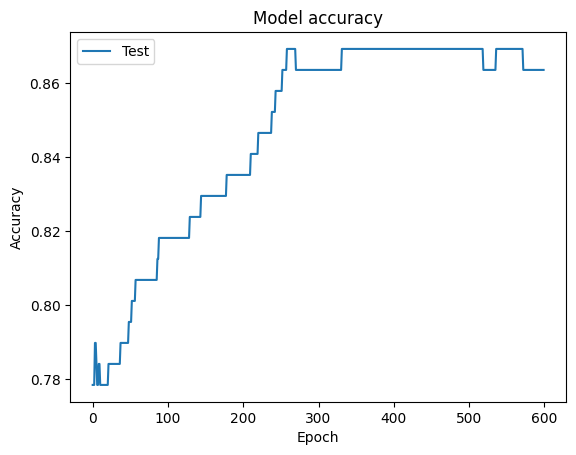

In [13]:
# Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()